<a href="https://colab.research.google.com/github/Amisha1019/Image-Colorization-and-Generative-AI/blob/main/Task_5_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers accelerate opencv-python pillow matplotlib


In [2]:
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation



In [4]:
img_path = "/content/images.jpeg"   # ← put your image here
image = Image.open(img_path).convert("RGB")
np_img = np.array(image)



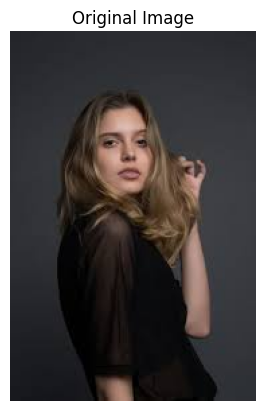

In [5]:
plt.imshow(np_img)
plt.title("Original Image")
plt.axis("off")
plt.show()


In [6]:
processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

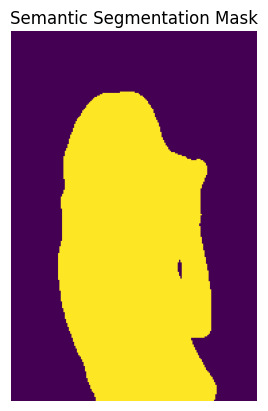

In [7]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
seg = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
seg = seg.cpu().numpy()

plt.imshow(seg)
plt.title("Semantic Segmentation Mask")
plt.axis("off")
plt.show()

In [8]:
PERSON_CLASS = 15

mask_fg = (seg == PERSON_CLASS).astype(np.uint8)
mask_bg = 1 - mask_fg


In [9]:
gray = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
gray_3c = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

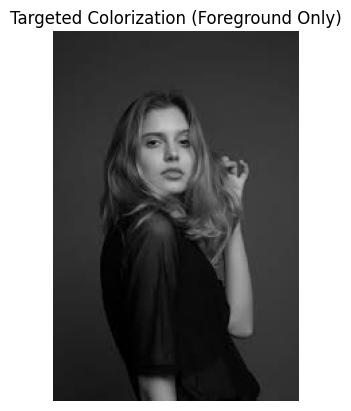

In [10]:
target_colorization = (np_img * mask_fg[...,None]) + (gray_3c * mask_bg[...,None])
target_colorization = target_colorization.astype(np.uint8)

plt.imshow(target_colorization)
plt.title("Targeted Colorization (Foreground Only)")
plt.axis("off")
plt.show()


In [11]:
def apply_style(image, strength=0.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,1] *= (1 + strength)   # boost saturation
    hsv[...,2] *= (1 + strength/2)
    hsv = np.clip(hsv, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)


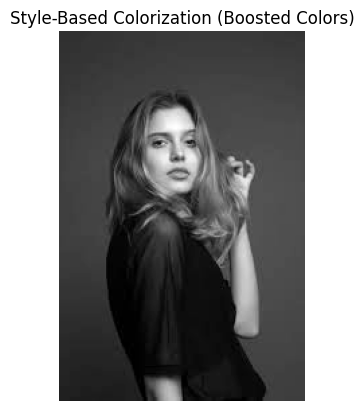

In [12]:
styled_color = apply_style(target_colorization, strength=0.6)

plt.imshow(styled_color)
plt.title("Style-Based Colorization (Boosted Colors)")
plt.axis("off")
plt.show()
